### Description:

In this task you will work with a binary (located at ../bin) that implements AES-128 algorithm with a hardcoded key.

To run the binary you need to provide 16-bytes plaintext in hex, as following:
```
    ../aesenc --ptext="010203040506070809000a0b0c0d0e1f"
```    
The result of the binary is printed to console:
```
    2DD52BC59D4196FE961054A06ECE1260 0404050604030403050506050304040407
```    
where:
```
    2DD52BC59D4196FE961054A06ECE1260 is a ciphertext
    
    0404050604030403050506050304040407 is a trace
```
### Tips:

A 'trace' is a side-channel information left by a programmer to debug the implementation.

In this example a trace is a 17 bytes long array. The first byte of this array is a Hamming weight of the mask. The following 16 bytes are Hamming weights of the masked State bytes at the beginning of the 10th round.

### Task:

Your task is to find a Master key (round key 0) embedded into the binary. 

The master key is in the form of HEIG{XXXXXXXXXX}, where X is a ASCII printable symbol.

In [2]:
import numpy as np
import binascii
import random
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import tqdm
import time
import datetime

import sca_training
import re
import socket

In [ ]:
HOST = 'iict-mv330-sfa'
PORT = 4004
#----------------------------------------------------------------------------
# This function calls tested binary ../aesenc either with a user-defined
# plaintext (if plaintext satisfies all the requirements) or with a
# predefined plaintext (the same as in the header above)
#
# INPUTS:
#     plaintext - a string of 32 symbols representing 16 hex bytes of ciphertext
#     verbose   - a flag to print values in the function call or not
# OUTPUTS:
#     output  - a raw binary output
#     ctext   - resulted ciphertext converted to numpy array of uint8
#     trace   - a trace associated with encryption process
#----------------------------------------------------------------------------
def binary_aes128_encrypt(plaintext, verbose=False):
    import subprocess
    pattern = '[0-9A-F]{32,34}'

    #Check the correctness of the plaintext
    if all(c in string.hexdigits for c in plaintext) and len(plaintext) == 32:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect((HOST, PORT))
            s.recv(1024)
            s.sendall(plaintext.encode())
            s.sendall(b'\n')

            output = s.recv(1024)


    #Get the ciphertext (first 32 symbols) and the trace (last 34 symbols)
    result = re.findall(pattern, str(output))
    #print(result[0], result[1])

    #Transform the result into numpy array
    ctext = np.frombuffer(binascii.unhexlify(result[0]), dtype=np.uint8)
    trace = np.frombuffer(binascii.unhexlify(result[1]), dtype=np.uint8)

    if (verbose):
        print('Binary output:', output.strip())
        print('Ciphertext as numpy array:', ctext)
        print('Trace as numpy array:', trace)

    return output, ctext, trace


#----------------------------------------------------------------------------
# This function calls supportive library to compute a master key from
# the last round key.
#
# INPUTS:
#     last_round_key - a numpy array of 16 elements representing 16 hex bytes of
#                      the last round key, i.e., Round Key 10
# OUTPUTS:
#     key_schedule  - 11 round keys of 16 bytes each (key_schedule[0,0,:] is the
#                     master key
#----------------------------------------------------------------------------
# key_schedule = sca_training.inverse_key_expansion(last_round_key)

In [ ]:
output, ctext, trace = binary_aes128_encrypt('010203040506070809000a0b0c0d0e1f', verbose=True)
print(len(output))
print(len(ctext))
print(len(trace))

In [ ]:
raise UserWarning("Dont' generate again lol")
num_enc = 10000

traces = np.zeros((num_enc, 17), dtype=np.uint8)
ctexts = np.zeros((num_enc, 16), dtype=np.uint8)

for iEnc in tqdm.tqdm(range(num_enc)):
    ptext = '%032x' % random.randrange(16**32)
    output, ctext, trace = binary_aes128_encrypt(ptext, verbose=False)
    ctexts[iEnc,:] = ctext
    traces[iEnc,:] = trace

np.save('traces.npy', traces)
np.save('ctexts.npy', ctexts)

del output
del ctext
del trace

In [3]:
traces = np.load('traces.npy')
ctexts = np.load('ctexts.npy')
print(traces.shape)
print(ctexts.shape)

(10000, 17)
(10000, 16)


### ATTACK CODE
Here you need to implement your attack which gives you the last round key.

Once the last round key is found - you need to compute the master key: this can be done with the function get_master_key()

### Programming tips
#### Numpy code
* np.matlib.repmat(array, num_rows, num_cols)
* np.arange(256).astype(np.uint8)
* np.bitwise_xor(m1, m2)
* np.where()

#### Code prepared for training
* sca_training.invSbox[sbox_out]
* sca_training.HW_uint8[sbox_in]
* sca_training.shift_rows(traces)
* sca_training.compute_correlation()

#### Various cod
* ''.join('{:02x}'.format(c) for c in int_array)

In [41]:
# Compute traces with absdiff
ms = traces[:,0]
dist_traces = np.array([np.subtract(np.maximum(d, ms), np.minimum(d, ms)) for d in traces[:,1:].T]).T

print(dist_traces.shape)
print(ctexts.shape)

(10000, 16)
(10000, 16)


In [51]:
# Compute traces with product of moment truc

# (HW(sbox) − E(HW(sbox))) * (HW(m) − E(HW(m)))
ms = traces[:,0].T
prec = ms - np.mean(ms)
dist_traces = np.array([(var - np.mean(var)) * prec for var in traces[:,1:].T]).T
print(dist_traces.shape)

(10000, 16)


In [52]:
def matrix_corrcoef(matrix, vector):
    return np.array([abs(np.corrcoef(vector, row)[0][1]) for row in matrix])


c = ctexts.T
t = dist_traces.T

k10_max = [0]*16
corrs_max = [[] for _ in range(16)]

for i in range(16):
    start_ms = round(time.time() * 1000)
    print("\n"+("*"*40))
    print(i)
    pcc = 0
    k_max = 0
    corr_max = []
    for k in range(256):
        cand = sca_training.HW_uint8[sca_training.invSbox[np.bitwise_xor(c[i], k)]]
        all_corr = matrix_corrcoef(t, cand)
        corr = max(all_corr)
        if corr > pcc:
            pcc = corr
            k_max = k
            corr_max = all_corr
            print(pcc)
    k10_max[i] = k_max
    corrs_max[i] = corr_max

    # Useless time dump to show progression
    stop_ms = round(time.time() * 1000)
    duration = round((stop_ms - start_ms) / 1000)
    length = str(datetime.timedelta(seconds=duration))
    print(f"Length : {length}")
    duration = duration * (15 - i)
    length = str(datetime.timedelta(seconds=duration))
    print(f"Left   : {length}")


****************************************
0
0.060650495706809096
0.06273613308185977
0.34703304159233805
Length : 0:00:00
Left   : 0:00:00

****************************************
1
0.023291384621738635
0.030269656185387985
0.03129633655299721
0.032822888420377457
0.034632426128814744
0.04267612093553532
0.050857361598102245
0.3468724016299929
Length : 0:00:00
Left   : 0:00:00

****************************************
2
0.022487199676752802
0.034262464478412163
0.0640498856457268
0.06568542738963606
0.07519433416910777
0.3369001085286151
Length : 0:00:00
Left   : 0:00:00

****************************************
3
0.018076636006497247
0.03329902416317954
0.04203314153733163
0.042107716616184274
0.3207035223850603
Length : 0:00:00
Left   : 0:00:00

****************************************
4
0.02305570248701123
0.030594500565897187
0.03135086644134094
0.04983656728751843
0.06829676866051813
0.0804261870556341
0.3361846725319176
Length : 0:00:00
Left   : 0:00:00

************************

In [47]:
mk = sca_training.inverse_key_expansion(np.array(k10_max))[0][0]
flag = ''.join(chr(c) for c in mk)
print(flag)

HEIG{maskarade!}


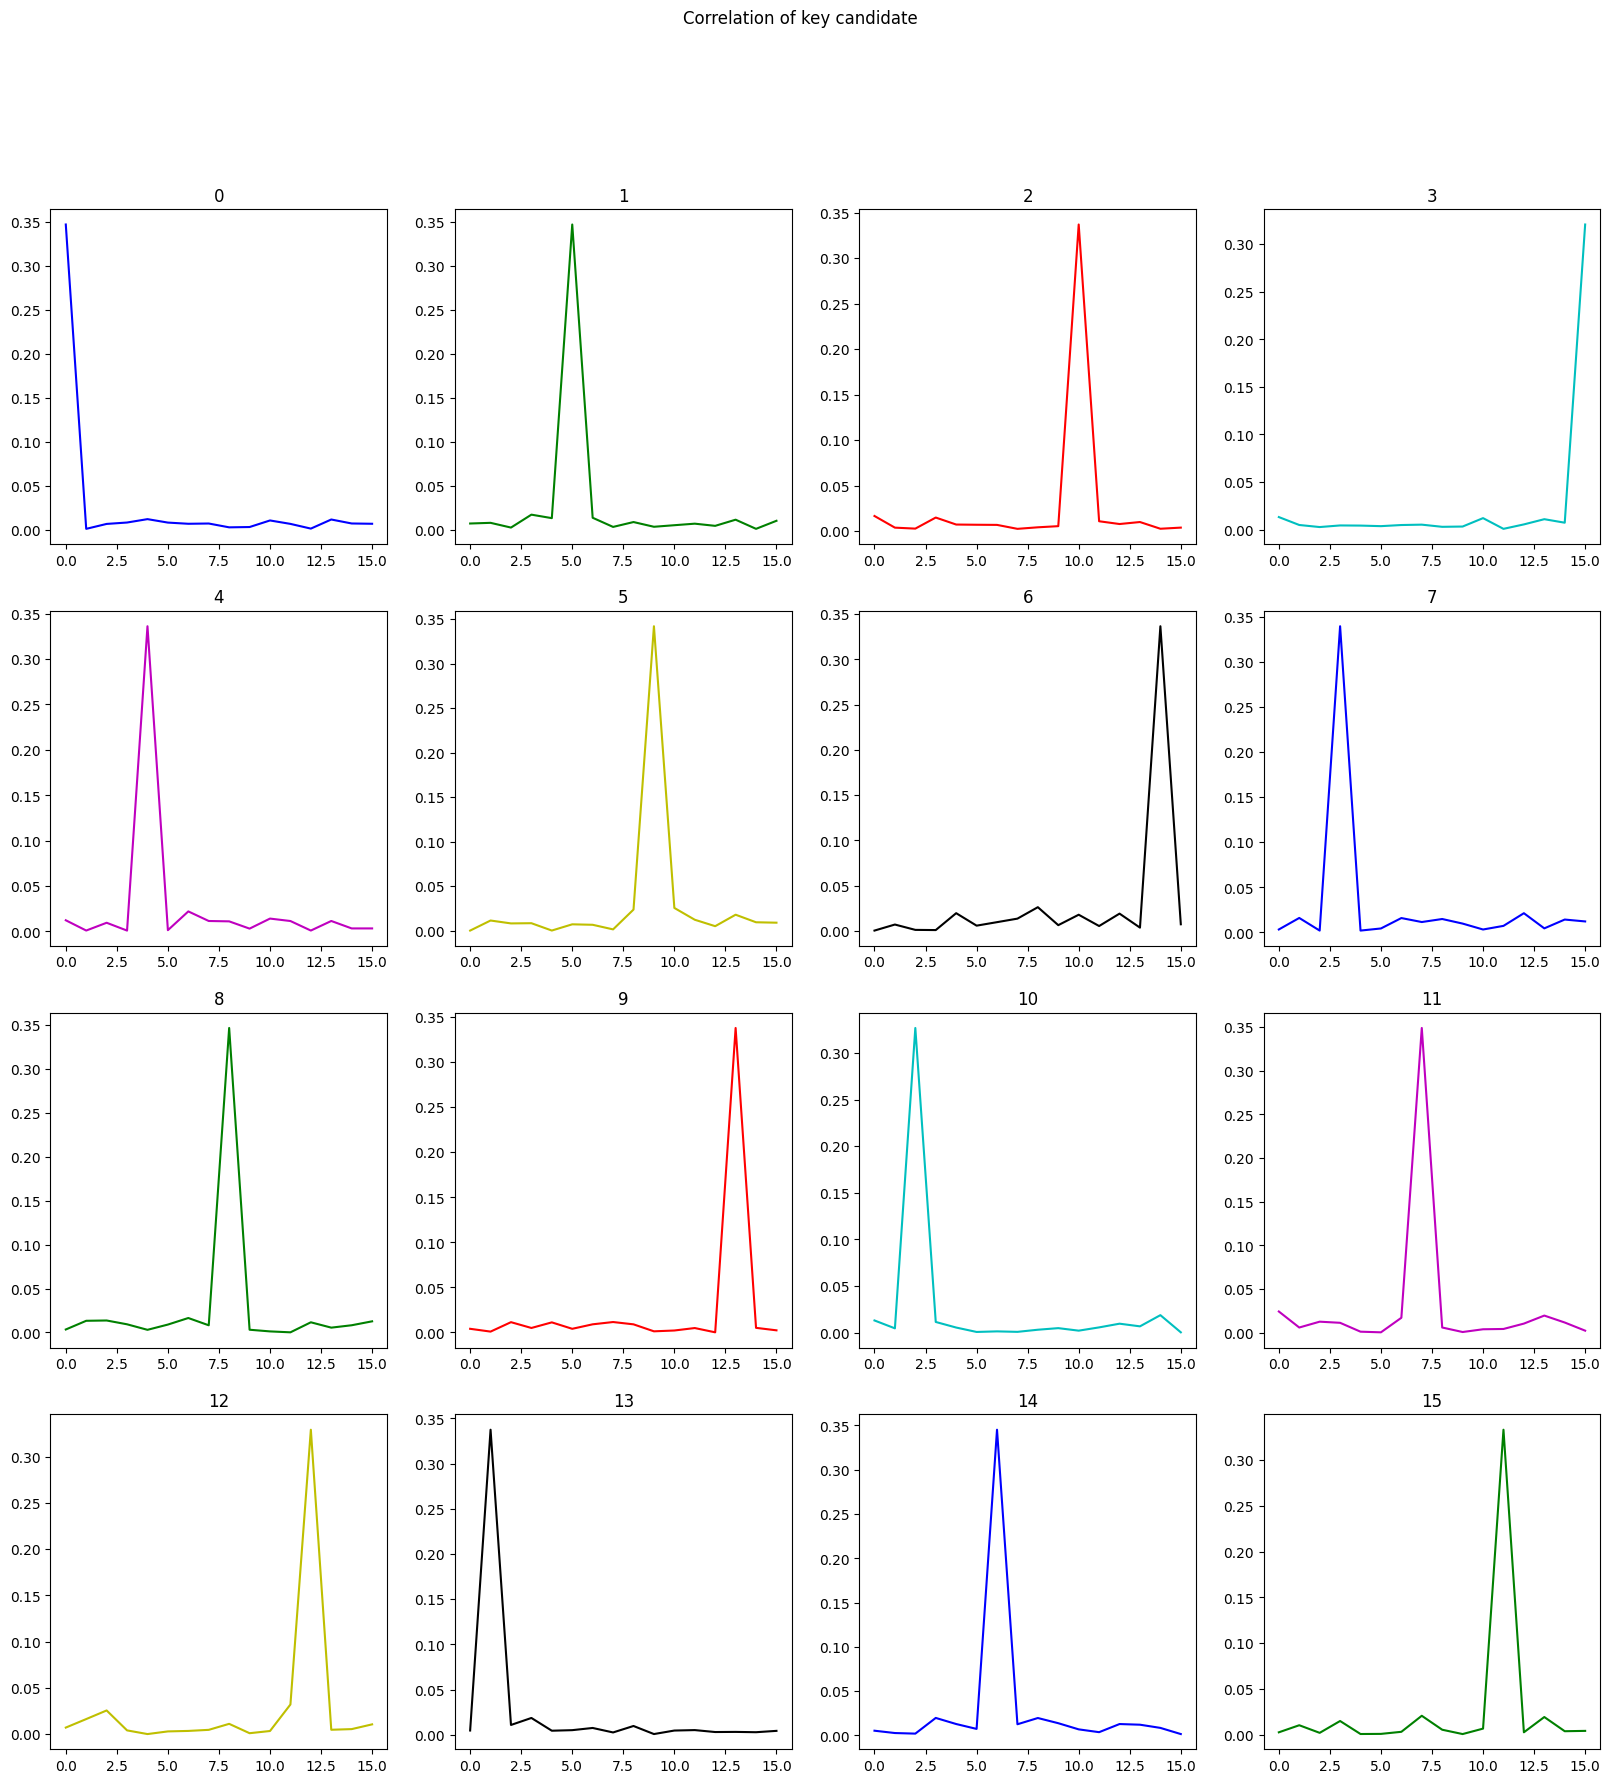

In [53]:
# Correlation visualisation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
fig.suptitle("Correlation of key candidate")
i = 0
for x in ax:
    for y in x:
        y.set_title(i)
        y.plot(corrs_max[i],label=i,color=colors[i%7])
        i += 1